In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from tensorflow.keras.utils import plot_model


import re
import string
import spacy
import pickle

In [3]:
# Load spaCy English language model
nlp = spacy.load("en_core_web_sm")

In [4]:
# Loading the data
data = pd.read_csv("tweets.csv", encoding='latin')
#get jusr target and text 
data = data[['Target', 'Text']]

In [5]:
data

,Target,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1048570,4,My GrandMa is making Dinenr with my Mum
1048571,4,Mid-morning snack time... A bowl of cheese noo...
1048572,4,@ShaDeLa same here say it like from the Termi...
1048573,4,@DestinyHope92 im great thaanks wbuu?


In [6]:
data.shape


(1048575, 2)

In [7]:
#get sample data  50,000
data=data.sample(50000)

In [8]:
print("Dataset shape : ",data.shape)


Dataset shape :  (50000, 2)


In [9]:
data['Target'].value_counts()


0    38125
4    11875
Name: Target, dtype: int64

In [10]:
data['Target'] = data['Target'].replace(4, 1)


In [11]:
data['Target'].value_counts()


0    38125
1    11875
Name: Target, dtype: int64

In [12]:
data.Target.describe()


count    50000.000000
mean         0.237500
std          0.425555
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Target, dtype: float64

In [13]:
# Balancing the dataset
min_count = data['Target'].value_counts().min()
balanced_data = pd.concat([data[data['Target'] == target].sample(min_count, replace=False) for target in data['Target'].unique()])
data = balanced_data.sample(frac=1).reset_index(drop=True)

In [14]:
data['Target'].value_counts()


0    11875
1    11875
Name: Target, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23750 entries, 0 to 23749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  23750 non-null  int64 
 1   Text    23750 non-null  object
dtypes: int64(1), object(1)
memory usage: 371.2+ KB


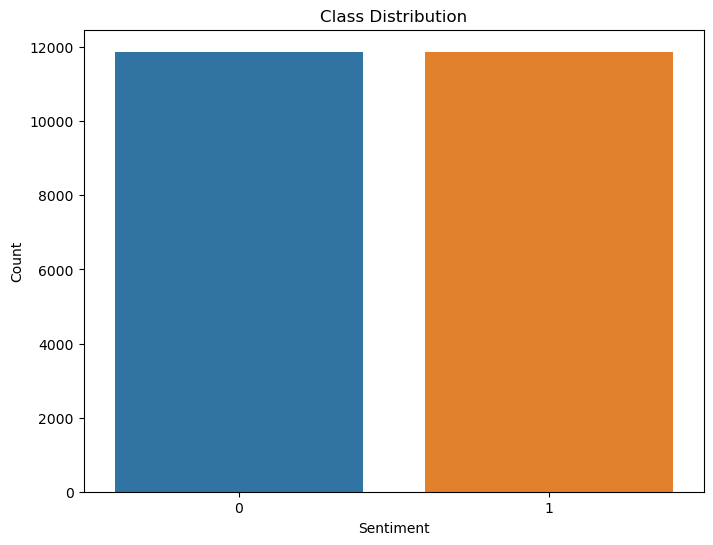

In [16]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Target' , data=data)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

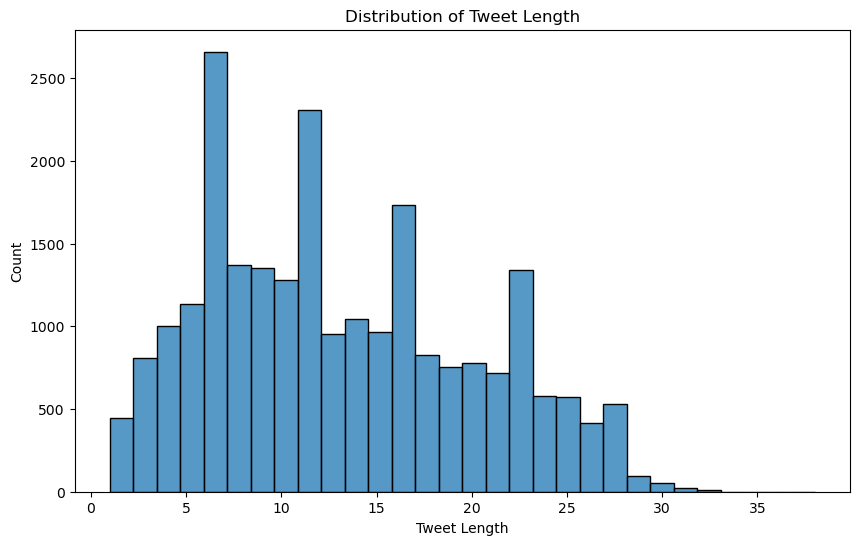

In [17]:
# Explore tweet length
data['Tweet_Length'] = data['Text'].apply(lambda x: len(x.split()))

# Visualize tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Tweet_Length'], bins=30)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

In [18]:
# Explore word frequency
all_words = ' '.join(data['Text'])
words = all_words.split()
word_freq = pd.Series(words).value_counts()

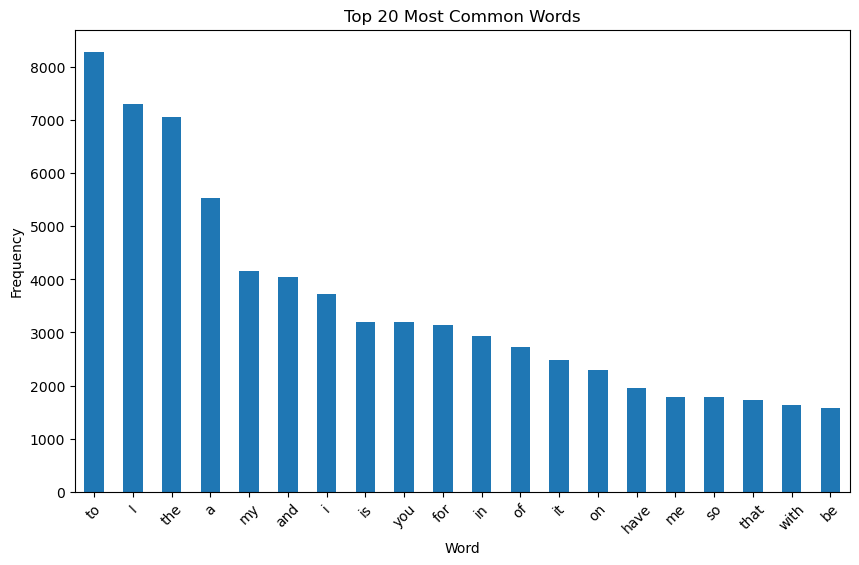

In [19]:
# Visualize top 20 most common words
plt.figure(figsize=(10, 6))
word_freq[:20].plot(kind='bar')
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Processing tweets
def process_tweets(tweet):
    tweet = tweet.lower()  # Convert text to lowercase
    tweet = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", "", tweet)  # Remove URLs
    tweet = re.sub(r'@[^\s]+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove non-alphabetic characters
    tweet = re.sub(r'\s+', ' ', tweet)  # Remove extra whitespaces
    tokens = nlp(tweet)  # Tokenize using spaCy
    lemmatized_tokens = [token.lemma_ for token in tokens if not token.is_stop and token.is_alpha]  # Lemmatize and remove stop words
    return ' '.join(lemmatized_tokens)

In [21]:
#prossing to data
data['processed_tweets'] = data['Text'].apply(process_tweets)


In [22]:
# Splitting data into features and target
X = data['processed_tweets'].values
y = data['Target'].values

In [23]:
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [24]:
# Tokenize and pad sequences
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=101)


In [26]:
# Define RNN model with a tall (deep) architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [27]:
# Define optimizer with an initial learning rate
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

# Compile the model with optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Define a learning rate scheduler callback
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model without specifying epochs
history = model.fit(X_train, y_train, batch_size=124, callbacks=[early_stopping, reduce_lr_callback], validation_data=(X_test, y_test))



154/154 [==============================] - 979s 6s/step - loss: 0.6202 - accuracy: 0.6329 - val_loss: 0.5298 - val_accuracy: 0.7324 - lr: 0.0010


In [28]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

149/149 [==============================] - 40s 268ms/step - loss: 0.5298 - accuracy: 0.7324
Test Loss: 0.5298, Test Accuracy: 0.7324


In [29]:
#summary mode
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 200, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

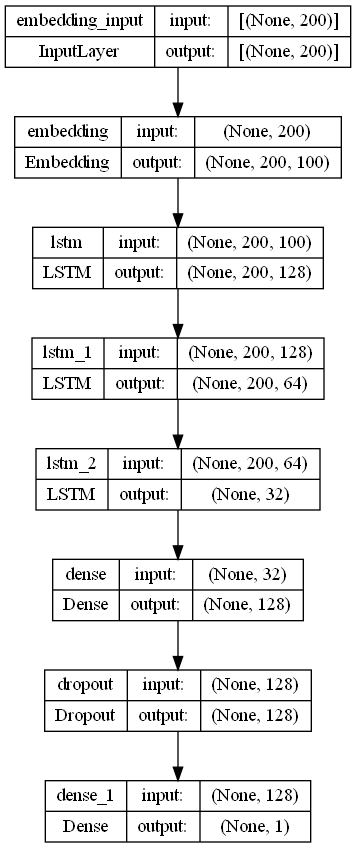

In [30]:
# Visualize model architecture
plot_model(model, to_file='architecture_model_layers.png', show_shapes=True)

In [31]:
# Predictions
y_pred = model.predict(X_test)

# Convert y_pred to binary values
y_pred_binary = (y_pred > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

149/149 [==============================] - 40s 242ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      2350
           1       0.74      0.73      0.73      2400

    accuracy                           0.73      4750
   macro avg       0.73      0.73      0.73      4750
weighted avg       0.73      0.73      0.73      4750



In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy on Test Data: {accuracy:.4f}')

Accuracy on Test Data: 0.7324


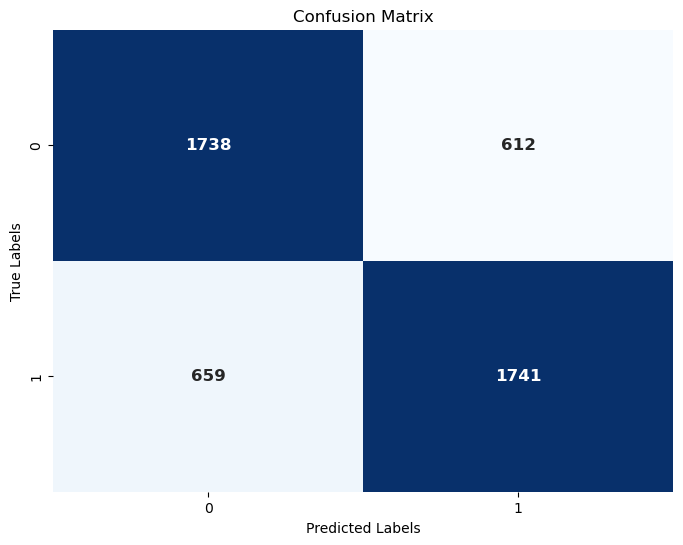

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [34]:
# Convert text to sequence of integers using tokenizer
sequence = tokenizer.texts_to_sequences(['this article is very beautiful'])
# Pad sequences to ensure consistent length
test = pad_sequences(sequence, maxlen=max_len)
# Predict sentiment using the trained model
predict = model.predict(test)
# Determine sentiment based on predicted probability
if predict > 0.5:
    print("Positive")
else:
    print("Negative")

1/1 [==============================] - 0s 217ms/step
Positive


In [35]:
# Saving  model
model.save('rnn_model.h5')

C:\Users\himan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
